# Talktorial 5

# Compound clustering

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Calvinna Caswara and Gizem Spriewald

## Aim of this talktorial

Similar compounds might bind to the same targets and show similar effects.  
Based on this **similar property principle**, compound similarity can be used to build chemical groups via clustering.  
From such a clustering, a **diverse set of compounds** can also be selected from a larger set of screening compounds for further experimental testing.

## Learning goals

In this talktorial, we will learn more about:

* How to group compounds and how to pick a diverse set of compounds
* Short introduction to two clustering algorithms
* Application of the Butina clustering algorithm to a sample compound set

### Theory

* Introduction to clustering and Jarvis-Patrick algorithm
* Detailed explanation of Butina clustering
* Picking diverse compounds

### Practical

* Examples for Butina clustering and compound picking

## References

* Butina, D. Unsupervised Data Base Clustering Based on Daylight’s Fingerprint and Tanimoto Similarity: A Fast and Automated Way To Cluster Small and Large Data Set. J. Chem. Inf. Comput. Sci. 1999.
* Leach, Andrew R., Gillet, Valerie J. An Introduction to Chemoinformatics. 2003
* Jarvis-Patrick Clustering: http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Jarvis-Patrick_Clustering_Overview.htm
* TDT Tutorial: https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb
* rdkit clustering documentation: http://rdkit.org/docs/Cookbook.html#clustering-molecules

_____________________________________________________________________________________________________________________


# Theory 

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) can be defined as 'the task of grouping a set of objects in such a way that objects in the **same group** (called a cluster) are **more similar** (in some sense) to each other than to **those in other groups** (clusters)'.

Compound clustering in pharmaceutical research is often based on chemical or structural similarity between compounds to find groups that share properties as well as to design a diverse and representative set for further analysis. 

General procedure: 

* Method are based on clustering data by similarity between neighboring points. 
* In cheminformatics, compounds are often encoded as molecular fingerprints and similarity can be described by the Tanimoto similarity (see **talktorial 4**).
    * As a quick reminder: Fingerprints are binary vectors where each bit indicates the presence or absence of a particular substructural fragment within a molecule. 
    * Similarity (or distance) matrix: The similarity between each pair of molecules represented by binary fingerprints is most frequently quantified using the Tanimoto coefficient, which measures the number of common features (bits). 
    * The value of the Tanimoto coefficient ranges from **zero (no similarity) to one (high similarity)**.

## Jarvis-Patrick algorithm

There are a number of clustering algorithms available, with the [Jarvis-Patrick clustering](http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Jarvis-Patrick_Clustering_Overview.htm) being one of the most widely used algorithms in the pharmaceutical context.

Jarvis-Patrick clustering algorithm is defined by two parameters K and K<sub>min</sub>:
* Calculate the set of K nearest neighbors for each molecule. 
* Two molecules cluster together if 
    * they are in each others list of nearest neighbors
    * they have at least K<sub>min</sub> of their K nearest neighbors in common.

The Jarvis-Patrick clustering algorithm is **deterministic** and able to deal with large sets of molecules in a matter of a few hours.  
However, a **downside** lies in the fact that this method tends to **produce large heterogeneous clusters**. 

More clustering algorithms can also be found in the [scikit-learn clustering module](http://scikit-learn.org/stable/modules/clustering.html).

## Butina clustering

Butina clustering ([*J. Chem. Inf. Model.*(1999), 39(4), 747](https://pubs.acs.org/doi/abs/10.1021/ci9803381)) was developed to identify **smaller but homogeneous** clusters, with the prerequisite that (at least) the cluster centroid will be more similar than a **given threshold** to every other molecule in the cluster.

These are the key steps in this clustering approach (see flowchart below):

#### 1. Data preparation and compound encoding
* To identify chemical similarities, the compounds in the input data (e.g. given as SMILES) will be encoded as molecular fingerprints, e.g., RDK5 fingerprint which is a subgraph-based fingerprint similar to the well known [Daylight Fingerprint](/http://www.daylight.com/dayhtml/doc/theory/theory.finger.html) (which was used in the original publication).


#### 2. Tanimoto similarity (or distance) matrix
* The similarity between two fingerprints is calculated using the Tanimoto coefficient.
* Matrix with Tanimoto similarities between all possible molecule/fingerprint pairs (n*n similarity matrix with n=number of molecules, upper triangle matrix used only)
* Equally, the **distances matrix** can be calculated (1 - similarity)

#### 3. Clustering molecules: Centroids and exclusion spheres 
Note: Molecules will be clustered together, if they have a maximum distance below a specified cut-off from the cluster centroid (if distance matrix is used) or if they have a minimum similarity above the specified cut-off (if similarity matrix is used).  

* **Identification of potential cluster centroids**
    * The cluster centroid is the molecule within a given cluster which has the **largest number of neighbors**.
    * Annotate neighbors: For each molecule count all molecules with a Tanimoto distance below a given threshold.
    * Sort the molecules by their number of neighbors in descending order, so that potential cluster centroids (i.e. the compounds with the largest number of neighbors) are placed at the top of the file.  

* **Clustering based on the exclusion spheres**
    * Starting with the first molecule (centroid) in the sorted list
        * All molecules with a Tanimoto index above or equal to the cut-off value used for clustering then become members of that cluster (in case of similarity).
            * Each molecule that has been identified as a member of the given cluster is **flagged and removed from further comparisons**. Thus, flagged molecules cannot become either another cluster centroid or a member of another cluster. This process is **like putting an exclusion sphere** around the newly formed cluster.
            * Once the first compound in the list has found all its neighbors, the first available (i.e. not flagged) compound at the top of the list becomes the new cluster centroid.
        * The same process is repeated for all other unflagged molecules down the list.
    * Molecules that have not been flagged by the end of the clustering process become singletons.
        * Note that some molecules assigned as singletons can have neighbors at the given Tanimoto similarity index, but those neighbors have been excluded by a stringer cluster centroid.

In [1]:
from IPython.display import IFrame
IFrame('images/butina_full.pdf', width=600, height=300)

*Figure 1:* Theoretical example of the Butina clustering algorithm, drawn by Calvinna Caswara.

### Picking diverse compounds

Finding **representative sets of compounds** is a concept often used in pharmaceutical industry.

* Let's say, we applied a virtual screening campaign but only have a **limited amount of resources** to experimentally test a few compounds in a confirmatory assay.  
* In order to obtain as much information as possible from this screen, we want to select a **diverse set**. Thus, we pick one representative of each chemical series in our list of potentially active compounds.

Another scenario would be to select **one series** to gain information about the **structure-activity relationship(SAR)**, i.e., how do small structural changes in the molecule affect the in vitro activity.

## Practical

### Example using the Butina Clustering Algorithm
Application is following the example of [TDT tutorial notebook by S. Riniker and G. Landrum](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb).

#### 1. Load data and calculate fingerprints
In this part the data is prepared and fingerprints are calculated.

In [2]:
# Import packages
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
import random
from random import choices
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.DataStructs import cDataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole

In [3]:
import os 
import pickle
import sys
import importlib

from nbautoeval import run_yaml_quiz
from nbautoeval.storage import storage_clear

sys.path.insert(1, f'../corrections/exercices')
from T5_cmpd_clustering import exo_tan_dist_mat
# from T5_cmpd_clustering import exo_

In [4]:
# Load and have a look into data
# Filtered data taken from talktorial 2
compound_df= pd.read_csv('../data/T2/EGFR_compounds_lipinski.csv',sep=";")

# print the shape of the dataframe
print('data frame shape:',compound_df.shape)

data frame shape: (4523, 10)


,molecule_chembl_id,units,IC50,smiles,pIC50,MW,HBA,HBD,LogP,rule_of_5
0,CHEMBL63786,nM,0.003,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,yes
1,CHEMBL53711,nM,0.006,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,yes
2,CHEMBL35820,nM,0.006,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,yes
3,CHEMBL53753,nM,0.008,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,yes
4,CHEMBL66031,nM,0.008,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,yes


In [ ]:
# show the first lines of the dataframe
compound_df.head()

In [6]:
# Create a list of tuples composed of (RDKit molecule object, ChEMBL_ID) 
# from the dataframe "compound_df"

# First, create an empty list called "mols"
mols = []

# Iterate over the dataframe 
for index, molecule in compound_df.iterrows():
    chemblId = molecule['molecule_chembl_id']
    smiles = molecule['smiles']
    mols.append((Chem.MolFromSmiles(smiles), chemblId))

# show the 5 first elements from the list
mols[0:5]

[(<rdkit.Chem.rdchem.Mol at 0x7fcdb799fa30>, 'CHEMBL63786'),
 (<rdkit.Chem.rdchem.Mol at 0x7fcdb799ff30>, 'CHEMBL53711'),
 (<rdkit.Chem.rdchem.Mol at 0x7fcdb799f710>, 'CHEMBL35820'),
 (<rdkit.Chem.rdchem.Mol at 0x7fcdb799f670>, 'CHEMBL53753'),
 (<rdkit.Chem.rdchem.Mol at 0x7fcdb799f5d0>, 'CHEMBL66031')]

In [ ]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(m) for m,idx in mols]

In [7]:
# How many compounds/fingerprints do we have?
# print the number of compounds converted
print('Number of compounds converted:',len(fingerprints))
# print the fingerprint length for the first compound
print('Fingerprint length per compound:',len(fingerprints[0]))

Number of compounds converted: 4523
Fingerprint length per compound: 2048


#### 2.  Tanimoto similarity and distance matrix
Now that we generated fingerprints, we move on to the next step: The identification of potential cluster centroids.  
For this, we define functions to calculate the Tanimoto similarity and distance matrix.

In [9]:
# fingerprints_str = [fp.ToBitString() for fp in fingerprints]
# fname = "fingerprints_str_T5.p"
# os.chdir("/home/peyrat/codes/gson_2021/cours_4/data")
# with open(fname, "wb") as fw:
#     pickle.dump(fingerprints_str, fw)
# os.chdir("/home/peyrat/codes/gson_2021/cours_4")

In [10]:
importlib.reload(sys.modules['T5_cmpd_clustering'])
from T5_cmpd_clustering import exo_tan_dist_mat

In [11]:
exo_tan_dist_mat.example()

GridBox(children=(HTML(value='<span style="font-size:medium;"\'>arguments</span>', _dom_classes=('header',)), …

In [45]:
def Tanimoto_distance_matrix_eval(fp_list_str):
    fp_list = [DataStructs.cDataStructs.CreateFromBitString(fp_str) for fp_str in fp_list_str]
    return Tanimoto_distance_matrix(fp_list)

In [48]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        for sim in similarities:
            dissimilarity_matrix.append(1-sim)
    return dissimilarity_matrix

In [49]:
exo_tan_dist_mat.correction(Tanimoto_distance_matrix_eval)

GridBox(children=(HTML(value='<span style="font-size:medium;"\'>arguments</span>', _dom_classes=('header', '')…

See also [rdkit Cookbook: Clustering molecules](http://rdkit.org/docs/Cookbook.html#clustering-molecules).

In [44]:
# Example: Calculate Tanimoto similarity of first two fingerprints
sim = DataStructs.TanimotoSimilarity(fingerprints[0],fingerprints[1])
print(f'Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}')

Tanimoto similarity: 0.68, distance: 0.32


In [16]:
# Example: Calculate distance matrix (distance = 1-similarity)
Tanimoto_distance_matrix(fingerprints)[0:5]

[0.31818181818181823,
 0.31474103585657376,
 0.430976430976431,
 0.26991150442477874,
 0.07111111111111112]

In [17]:
# Side note: That looked like a list and not a matrix. 
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n*(n-1))/2
print(int(elem_triangular_matr), len(Tanimoto_distance_matrix(fingerprints)))

10226503 10226503


#### 3. Clustering molecules: Centroids and exclusion spheres
In this part, we cluster the molecules and look at the results.

Define a clustering function.

In [18]:
importlib.reload(sys.modules['T5_cmpd_clustering'])
from T5_cmpd_clustering import exo_clustFp

In [19]:
exo_clustFp.example()

GridBox(children=(HTML(value='<span style="font-size:medium;"\'>arguments</span>', _dom_classes=('header',)), …

In [20]:
def ClusterFps_eval(fp_list_str, cutoff=0.2):
    fp_list = [DataStructs.cDataStructs.CreateFromBitString(fp_str) for fp_str in fp_list_str]
    return ClusterFps(fp_list, cutoff=0.2)

In [21]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps,cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [22]:
exo_clustFp.correction(ClusterFps_eval)

GridBox(children=(HTML(value='<span style="font-size:medium;"\'>arguments</span>', _dom_classes=('header', '')…

Cluster the molecules based on their fingerprint similarity.

In [23]:
# Run the clustering procedure for the dataset
clusters = ClusterFps(fingerprints,cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = len([c for c in clusters if len(c) == 1])
num_clust_g5 = len([c for c in clusters if len(c) > 5])
num_clust_g25 = len([c for c in clusters if len(c) > 25])
num_clust_g100 = len([c for c in clusters if len(c) > 100])

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  681
# clusters with only 1 compound:  305
# clusters with >5 compounds:  157
# clusters with >25 compounds:  33
# clusters with >100 compounds:  4


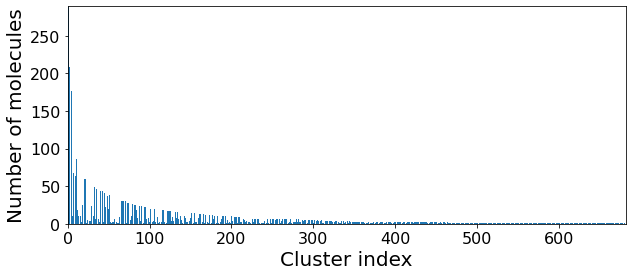

In [24]:
# Plot the size of the clusters
fig = plt.figure(1, figsize=(10, 4))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('Number of molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.show()

#### How to pick a reasonable cutoff?
Since the clustering result depends on the threshold chosen by the user, we will have a closer look on the choice of a cutoff.

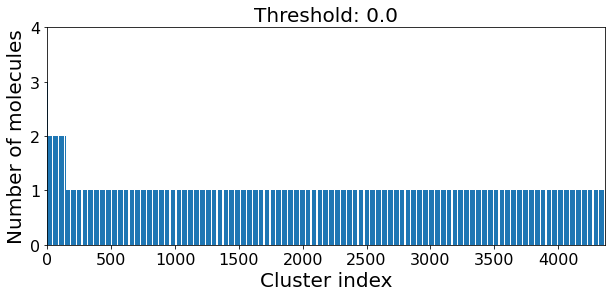

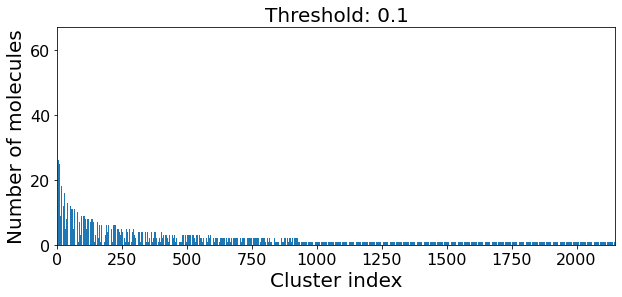

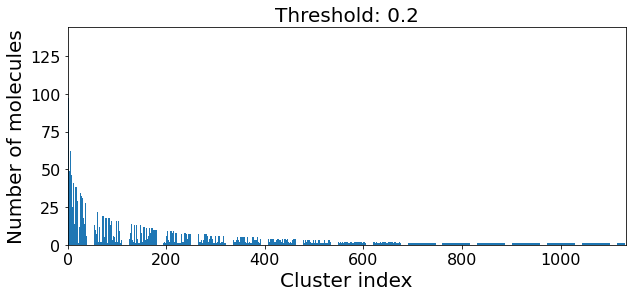

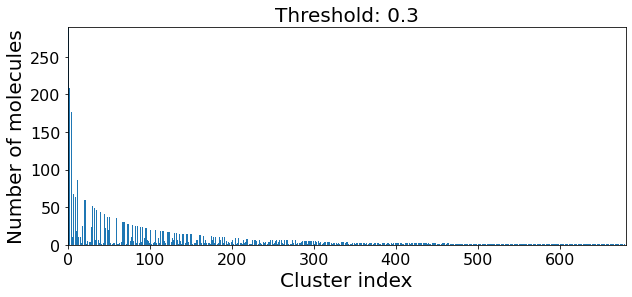

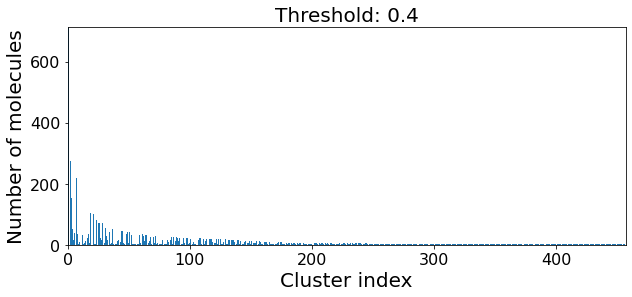

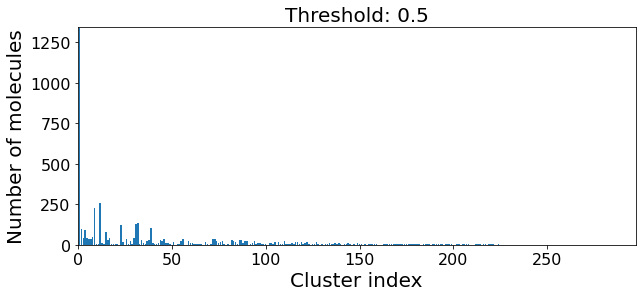

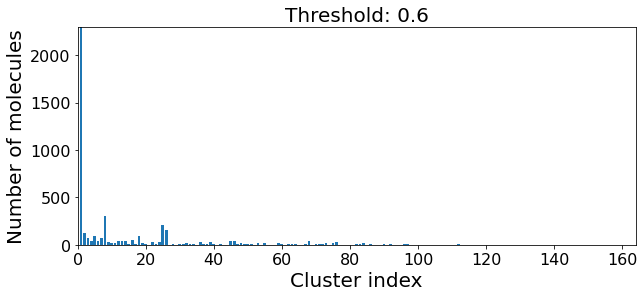

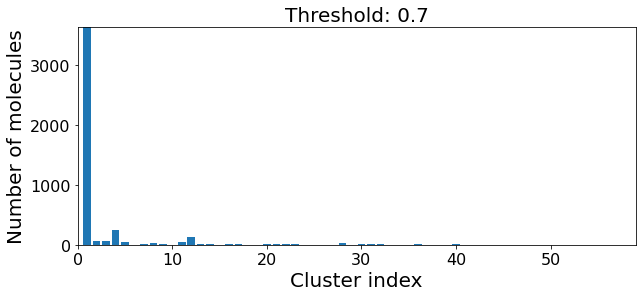

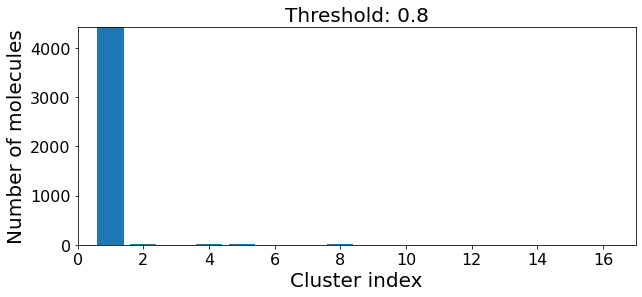

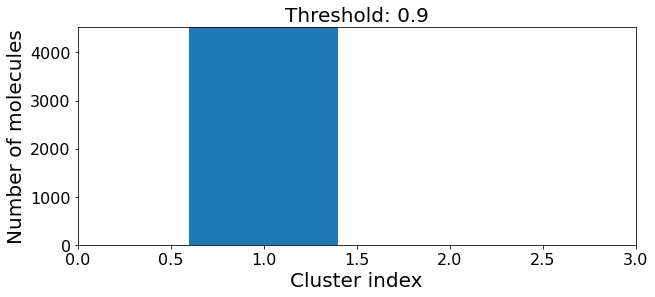

In [25]:
for i in numpy.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fingerprints,cutoff=i)
    fig = plt.figure(1, figsize=(10, 4))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %i), fontsize=20)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

As you can see, the higher the threshold (distance cutoff), the more molecules are considered as similar and, therefore, clustered into less clusters.
The lower the threshold, the more small clusters and "singletons" appear.
* The smaller the distance value cut-off, the more similar the compounds are required to be to belong to one cluster.

Looking at the plots above, we decided to choose a distance threshold of 0.2. There are not many singletons and the cluster sizes don't have an extreme but smooth distribution.

Number of clusters 1132 from 4523 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 143
Similarity between two random points in same cluster 0.92
Similarity between two random points in different cluster 0.30


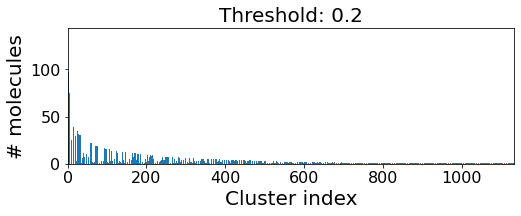

In [26]:
dist_co = 0.2
clusters = ClusterFps(fingerprints,cutoff=dist_co)

# Plot the size of the clusters - save plot
fig = plt.figure(1, figsize=(8, 2.5))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('# molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.title('Threshold: '+str('%3.1f' %dist_co), fontsize=20)
plt.savefig("../data/T5/cluster_dist_cutoff_%4.2f.png" %dist_co, dpi=300, bbox_inches="tight", transparent=True)

print('Number of clusters %d from %d molecules at distance cut-off %4.2f' %(len(clusters), len(mols), dist_co))
print('Number of molecules in largest cluster:', len(clusters[0]))
print('Similarity between two random points in same cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[0][1]]))
print('Similarity between two random points in different cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[1][0]]))

### Cluster visualization

#### 10 examples from largest cluster

Now, let's have a closer look at the first 10 molecular structures of the first/largest clusters.

Ten molecules from largest cluster:


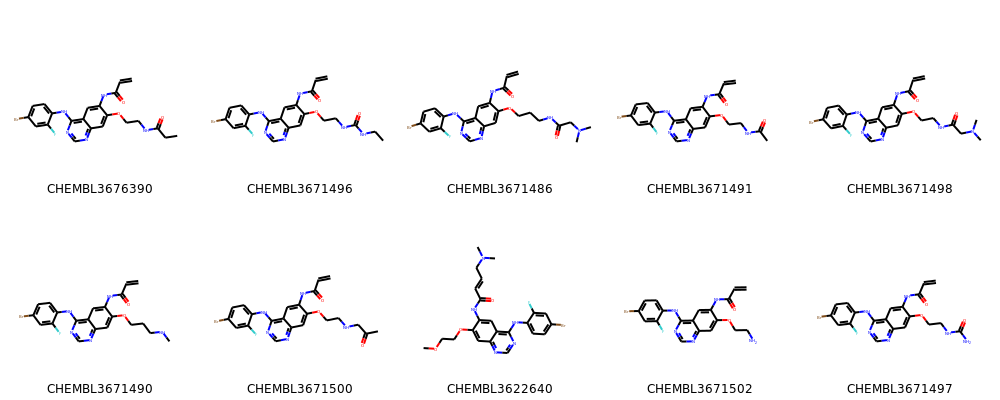

In [27]:
print ('Ten molecules from largest cluster:')
# Draw molecules
Draw.MolsToGridImage([mols[i][0] for i in clusters[0][:10]], 
                     legends=[mols[i][1] for i in clusters[0][:10]], 
                     molsPerRow=5)

In [28]:
# Save molecules from largest cluster for MCS analysis in Talktorial 9
w = Chem.SDWriter('../data/T5/molSet_largestCluster.sdf')

# Prepare data
tmp_mols=[]
for i in clusters[0]:
    tmp = mols[i][0]
    tmp.SetProp("_Name",mols[i][1])
    tmp_mols.append(tmp)  

# Write data
for m in tmp_mols: w.write(m)

#### 10 examples from second largest cluster

Ten molecules from second largest cluster:


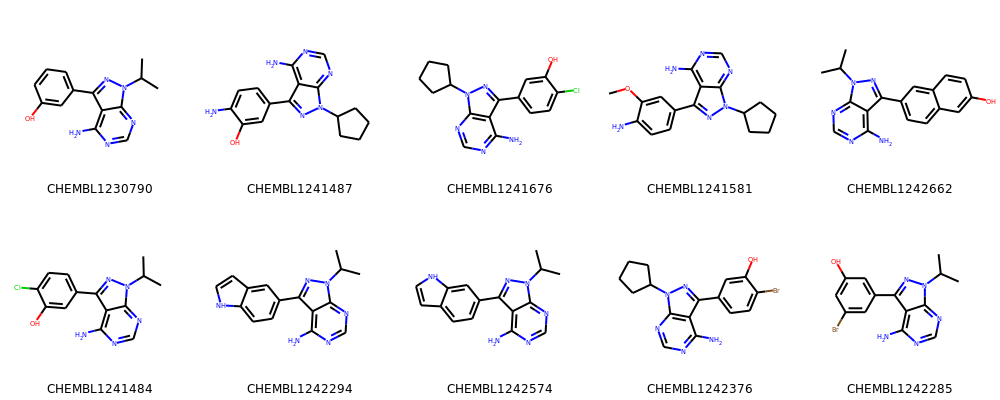

In [29]:
print ('Ten molecules from second largest cluster:')
# Draw molecules
Draw.MolsToGridImage([mols[i][0] for i in clusters[1][:10]], 
                     legends=[mols[i][1] for i in clusters[1][:10]], 
                     molsPerRow=5)

The first ten molecules in the respective clusters look indeed similar to each other and many share a **common scaffold** (visually detected). 

See **talktorial 6** for more information on how to calculate the **maximum common substructure (MCS)** of a set of molecules.

#### Examples from first 10 clusters

For comparison, we have a look at the **cluster centers** of the first 10 clusters.

Ten molecules from first 10 clusters:


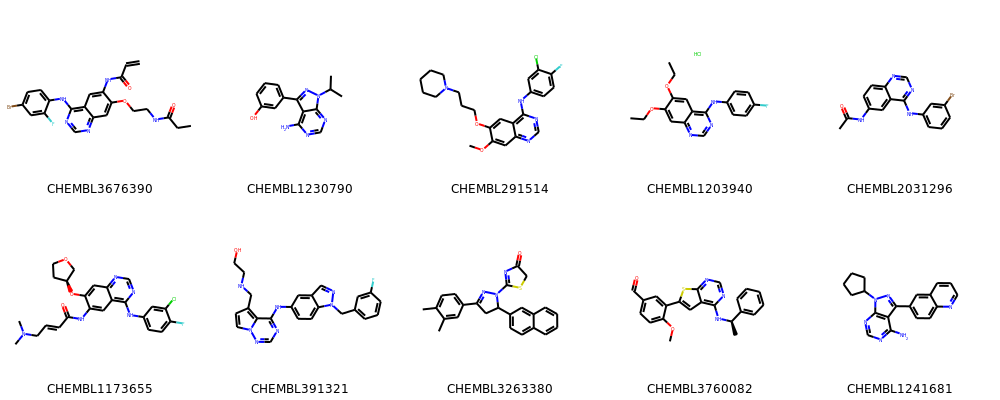

In [30]:
print ('Ten molecules from first 10 clusters:')
# Draw molecules
Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(10)], 
                     legends=[mols[clusters[i][0]][1] for i in range(10)], 
                     molsPerRow=5)

Save cluster centers from first 3 clusters as SVG file.

In [31]:
# Generate image
img = Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(0,3)],
                     legends=["Cluster "+str(i) for i in range(1,4)],
                     subImgSize=(200,200), useSVG=True)

# Get SVG data
molsvg = img.data

# Replace non-transparent to transparent background and set font size
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
molsvg = molsvg.replace("12px", "20px");

# Save altered SVG data to file
f = open("../data/T5/cluster_representatives.svg", "w")
f.write(molsvg)
f.close()

While still some similarity is visible, clearly, the centroids from the different clusters look more dissimilar then the compounds within one cluster.

#### Intra-cluster Tanimoto similarities

We can also have a look at the intra-cluster Tanimoto similarities.

In [32]:
# Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster
def IntraTanimoto(fps_clusters):
    intra_similarity =[]
    # Calculate intra similarity per cluster
    for k in range(0,len(fps_clusters)):
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1-x for x in Tanimoto_distance_matrix(fps_clusters[k])])
    return intra_similarity

In [33]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster=[]
for c in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(mols[i][0]) for i in c])

In [34]:
# Compute intra-cluster similarity 
intra_sim = IntraTanimoto(mol_fps_per_cluster)

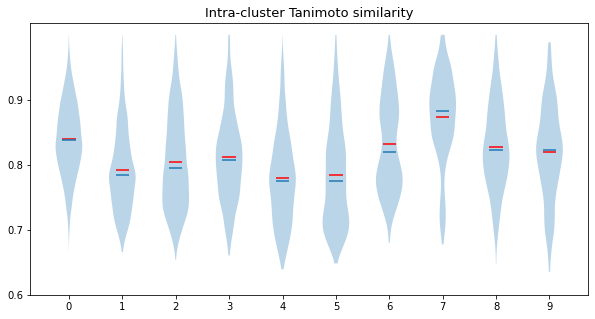

In [35]:
# Violin plot with intra-cluster similarity
pos = list(range(10))
labels = pos
plt.figure(1, figsize=(10, 5))
ax = plt.subplot(111)
r = plt.violinplot(intra_sim, pos, showmeans=True, showmedians=True, showextrema=False)
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.set_yticks(numpy.arange(0.6, 1., 0.1))
ax.set_title('Intra-cluster Tanimoto similarity', fontsize=13)
r['cmeans'].set_color('red')
# mean=red, median=blue

### Compound picking
In the following, we are going to pick a final list of **max. 1000 compounds** as a **diverse** subset. 

For this, we take the cluster centroid from each cluster (i.e. the first molecule of each cluster) and then we take - starting with the largest cluster - for each cluster the 10 molecules (or 50% if less than 10 molecules are left in the cluster) most similar to the centroid, until we have selected max. 1000 compounds. Thus, we have representatives of each cluster. 

Aim of this compound picking is to ensure the diversity for a smaller set of compounds which are proposed for testing in a confirmatory assay. 

Picking procedure was adapted from [TDT tutorial notebook by S. Riniker and G. Landrum](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb). 
As described there: The idea behind this approach is to ensure diversity (representatives of each cluster) while getting some SAR from the results of the confirmatory assay (groups of quite similar molecules from larger clusters retained).

Get cluster centers.

In [36]:
# Get the cluster center of each cluster (first molecule in each cluster)
clus_center = [mols[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print('Number of cluster centers: ', len(clus_center))

Number of cluster centers:  1132


Sort clusters by size and molecules in each cluster by similarity.

In [37]:
# Sort the molecules within a cluster based on their similarity 
# to the cluster center and sort the clusters based on their size
clusters_sort = []
for c in clusters:
    if len(c) < 2: continue # Singletons
    else:
        # Compute fingerprints for each cluster element
        fps_clust = [rdkit_gen.GetFingerprint(mols[i][0]) for i in c]
        # Similarity of all cluster members to the cluster center
        simils = DataStructs.BulkTanimotoSimilarity(fps_clust[0],fps_clust[1:])
        # Add index of the molecule to its similarity (centroid excluded!)
        simils = [(s,index) for s,index in zip(simils, c[1:])]
        # Sort in descending order by similarity
        simils.sort(reverse=True)
        # Save cluster size and index of molecules in clusters_sort
        clusters_sort.append((len(simils), [i for s,i in simils]))
        # Sort in descending order by cluster size
        clusters_sort.sort(reverse=True)

pick cluster centers first

In [38]:
# Count selected molecules, pick cluster centers first
sel_molecules = clus_center.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
diff = 1000 - len(sel_molecules)
while diff > 0  and index < len(clusters_sort):
    # Take indices of sorted clusters
    tmp_cluster = clusters_sort[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if clusters_sort[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5*len(c))+1
    if num_compounds > diff: 
        num_compounds = diff
    # Write picked molecules and their structures into list of lists called picked_fps
    sel_molecules += [mols[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    diff = 1000 - len(sel_molecules)
print('# Selected molecules: '+str(len(sel_molecules)))

# Selected molecules: 1132


This set of diverse molecules could now be used for experimental testing.

# Quiz

In [39]:
run_yaml_quiz(f"../corrections/quiz/T5_cmpd_clustering.yaml", "theoric-quiz")

In [40]:
storage_clear("quiz-T5-01")